# Loading the Data

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import (
    log_loss, 
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in range(2012, 2025):  # Adjusted to include 2012 for rolling window
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2012.parquet from cached data
Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_56363/2545760028.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,322450221037,32245022104,322450221,4,1,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,92,92,1,10,2,False,Rush,"Jamaine Cook rush for 2 yards to the YngSt 10,...",-0.207100,2,47
1,322450221048,32245022104,322450221,4,11,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,36,36,2,4,0,False,Rush,"Kurt Hess rush for no gain to the Pitt 36, tac...",-0.903926,15,0
2,322450221044,32245022104,322450221,4,7,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,1,10,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-1.138786,15,0
3,322450221045,32245022104,322450221,4,8,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,2,10,5,False,Pass Completion,Kurt Hess pass complete to Marcel Caver for 5 ...,0.068045,15,0
4,322450221041,32245022104,322450221,4,5,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,73,73,2,8,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-0.478808,2,47


In [7]:
elos = []
for year in range(2012, 2025):  # Adjusted to include 2012 for rolling window
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'season_type', 'team_id'], keep='first')
elo.head()

,season,week,season_type,team_id,team,division,elo
0,2012,1,regular,2,Auburn,fbs,2746.814245
1,2012,2,regular,2,Auburn,fbs,2682.892552
2,2012,3,regular,2,Auburn,fbs,2586.052374
3,2012,4,regular,2,Auburn,fbs,2588.228228
4,2012,6,regular,2,Auburn,fbs,2580.160704


In [8]:
elo.query('season == 2023 and team == "Wisconsin"')

,season,week,season_type,team_id,team,division,elo
41297,2023,1,regular,275,Wisconsin,fbs,2580.246288
41298,2023,2,regular,275,Wisconsin,fbs,2558.680755
41299,2023,3,regular,275,Wisconsin,fbs,2501.900824
41300,2023,4,regular,275,Wisconsin,fbs,2514.101223
41301,2023,6,regular,275,Wisconsin,fbs,2584.518593
41302,2023,7,regular,275,Wisconsin,fbs,2600.954521
41303,2023,8,regular,275,Wisconsin,fbs,2544.874054
41304,2023,9,regular,275,Wisconsin,fbs,2569.226962
41305,2023,10,regular,275,Wisconsin,fbs,2554.311961
41306,2023,11,regular,275,Wisconsin,fbs,2472.908381


In [9]:
game_team_stats_dir = join(DATA_DIR, 'game_team_stats')
if not os.path.exists(game_team_stats_dir):
    os.makedirs(game_team_stats_dir)

def flatten_team_data(row):
    game_id = row['id']
    teams_data = row['teams']
    
    # Parse the JSON string if it's not already parsed
    if isinstance(teams_data, str):
        teams_data = json.loads(teams_data)
    
    rows = []
    for team in teams_data:
        # Create base dictionary with non-stats fields
        team_row = {
            'game_id': game_id,
            'teamId': team['teamId'],
            'team': team['team'],
            'conference': team['conference'],
            'homeAway': team['homeAway'],
            'points': team['points']
        }
        
        # Add stats fields
        for stat in team['stats']:
            # Convert stat names to valid column names if needed
            col_name = stat['category']
            team_row[col_name] = stat['stat']
        
        rows.append(team_row)
    
    return rows

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'game_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        weeks = games.query('season == @year').week.unique().tolist()
        if not weeks:
            weeks = range(1, 16)

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} team stats data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.GamesApi(api_client)
                data = api_instance.get_game_team_stats(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                games_count = games.query('season == @year and week == @week and home_division == "fbs"').shape[0] + \
                    games.query('season == @year and week == @week and away_division == "fbs"').shape[0]
                print(f'No team stats data for {year} week {week}, number of FBS teams: {games_count}')
                continue

            flattened_data = []
            for _, row in tmp.iterrows():
                flattened_data.extend(flatten_team_data(row))
            result_df = pd.DataFrame(flattened_data)

            base_columns = ['game_id', 'teamId', 'team', 'conference', 'homeAway', 'points']
            stat_columns = [col for col in result_df.columns if col not in base_columns]
            result_df = result_df[base_columns + stat_columns]
            result_df.columns = convert_to_snake_case(result_df.columns)
            season_dfs.append(result_df)

        season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

        all_dfs.append(season_df)
        season_df.to_parquet(file_path)

team_stats = (
    games[['id', 'season', 'week', 'season_type']].rename(columns={'id': 'game_id'})
    .merge(
        pd.concat(all_dfs, ignore_index=True).reset_index(drop=True),
        on='game_id', how='left'
    )
    .dropna(subset=['team_id'])
    .sort_values(
        by=['season', 'season_type', 'week', 'team_id'], 
        ignore_index=True, 
        ascending=[True, False, True, True]
    )
)
team_stats.head()

Reading ../data/game_team_stats/2012.parquet from cached data
Reading ../data/game_team_stats/2013.parquet from cached data
Reading ../data/game_team_stats/2014.parquet from cached data
Reading ../data/game_team_stats/2015.parquet from cached data
Reading ../data/game_team_stats/2016.parquet from cached data
Reading ../data/game_team_stats/2017.parquet from cached data
Reading ../data/game_team_stats/2018.parquet from cached data
Reading ../data/game_team_stats/2019.parquet from cached data
Reading ../data/game_team_stats/2020.parquet from cached data
Reading ../data/game_team_stats/2021.parquet from cached data
Reading ../data/game_team_stats/2022.parquet from cached data
Reading ../data/game_team_stats/2023.parquet from cached data
Reading ../data/game_team_stats/2024.parquet from cached data


,game_id,season,week,season_type,team_id,team,conference,home_away,points,possession_time,interceptions,fumbles_lost,turnovers,total_penalties_yards,yards_per_rush_attempt,rushing_attempts,rushing_yards,yards_per_pass,completion_attempts,net_passing_yards,total_yards,fourth_down_eff,third_down_eff,first_downs,passes_intercepted,interception_tds,interception_yards,kicking_points,kick_returns,kick_return_tds,kick_return_yards,passing_tds,punt_returns,punt_return_tds,punt_return_yards,rushing_tds,fumbles_recovered,passes_deflected,qb_hurries,sacks,tackles,defensive_tds,tackles_for_loss,total_fumbles
0,322450002,2012,1,regular,2.0,Auburn,SEC,home,19.0,28:14,1,1,2,6-38,4.9,37,180,7.2,11-27,194,374,0-1,4-13,17,1,0,12,13,1,0,21,1,1,0,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,322450005,2012,1,regular,5.0,UAB,Conference USA,home,29.0,41:39,1,3,4,9-47,3.0,44,134,9.6,19-34,325,459,0-2,8-16,23,None,None,None,5,5,0,82,2,3,0,-6,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,322450006,2012,1,regular,6.0,South Alabama,Sun Belt,home,31.0,26:53,1,3,4,7-80,3.4,37,126,7.0,15-26,182,308,2-2,5-13,18,1,0,28,7,2,0,95,2,2,0,37,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,322450008,2012,1,regular,8.0,Arkansas,SEC,home,49.0,25:41,0,3,3,6-38,4.7,35,164,11.8,23-34,400,564,0-2,5-9,25,None,None,None,7,4,0,96,3,5,0,29,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,322430009,2012,1,regular,9.0,Arizona State,Pac-12,home,63.0,30:16,0,1,1,4-30,6.0,51,305,12.4,16-20,249,554,1-1,7-13,25,3,1,117,9,1,0,7,1,2,0,13,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
advanced_team_stats_dir = join(DATA_DIR, 'advanced_team_stats')
if not os.path.exists(advanced_team_stats_dir):
    os.makedirs(advanced_team_stats_dir)

def parse_stats(row):
    offense = row['offense']
    defense = row['defense']
    return pd.Series({
        'offense_ppa': offense.get('ppa'),
        'offense_successRate': offense.get('successRate'),
        'offense_explosiveness': offense.get('explosiveness'),
        'offense_passingPlays_ppa': offense.get('passingPlays', {}).get('ppa'),
        'offense_passingPlays_successRate': offense.get('passingPlays', {}).get('successRate'),
        'offense_passingPlays_explosiveness': offense.get('passingPlays', {}).get('explosiveness'),
        'offense_rushingPlays_ppa': offense.get('rushingPlays', {}).get('ppa'),
        'offense_rushingPlays_successRate': offense.get('rushingPlays', {}).get('successRate'),
        'offense_rushingPlays_explosiveness': offense.get('rushingPlays', {}).get('explosiveness'),
        'offense_stuffRate': offense.get('stuffRate'),
        'offense_lineYards': offense.get('lineYards'),
        'defense_ppa': defense.get('ppa'),
        'defense_successRate': defense.get('successRate'),
        'defense_explosiveness': defense.get('explosiveness'),
        'defense_passingPlays_ppa': defense.get('passingPlays', {}).get('ppa'),
        'defense_passingPlays_successRate': defense.get('passingPlays', {}).get('successRate'),
        'defense_passingPlays_explosiveness': defense.get('passingPlays', {}).get('explosiveness'),
        'offense_secondLevelYards': offense.get('secondLevelYards'),
        'offense_openFieldYards': offense.get('openFieldYards'),
        'defense_rushingPlays_ppa': defense.get('rushingPlays', {}).get('ppa'),
        'defense_rushingPlays_successRate': defense.get('rushingPlays', {}).get('successRate'),
        'defense_rushingPlays_explosiveness': defense.get('rushingPlays', {}).get('explosiveness'),
        'defense_stuffRate': defense.get('stuffRate'),
        'defense_lineYards': defense.get('lineYards'),
        'defense_secondLevelYards': defense.get('secondLevelYards'),
        'defense_openFieldYards': defense.get('openFieldYards'),
    })

all_dfs = []
for year in range(2012, 2025): # Include year prior to 2013 for rolling stats
    file_path = join(DATA_DIR, 'advanced_team_stats', f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
        all_dfs.append(tmp)
    else:
        regular_weeks = team_stats.query('season == @year and season_type=="regular"').week.unique().tolist()
        postseason_weeks = team_stats.query('season == @year and season_type=="postseason"').week.unique().tolist()

        season_dfs = []
        for season_type in ['regular', 'postseason']:
            weeks = regular_weeks if season_type == 'regular' else postseason_weeks
            for week in weeks:
                print(f'Fetching {year} team stats data for {season_type} week {week} from CFBD API')
                with cfbd.ApiClient(configuration) as api_client:
                    api_instance = cfbd.StatsApi(api_client)
                    data = api_instance.get_advanced_game_stats(
                        year=year,
                        week=week,
                        season_type=cfbd.SeasonType(season_type)
                    )
                tmp = pd.DataFrame([val.to_dict() for val in data])
                
                result_df = (
                    tmp.join(tmp.apply(parse_stats, axis=1))
                    .drop(columns=['offense', 'defense', 'opponent'])
                    .assign(season_type=season_type)
                )

                result_df.columns = convert_to_snake_case(result_df.columns)

                base_columns = ['game_id', 'season', 'team', 'season_type']
                stat_columns = [col for col in result_df.columns if col not in base_columns]
                result_df = result_df[base_columns + stat_columns]
                season_dfs.append(result_df)

            season_df = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)

            all_dfs.append(season_df)
            season_df.to_parquet(file_path)

advanced_team_stats = (
    pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
    .sort_values(
        by=['team', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)
advanced_team_stats.head()

Reading ../data/advanced_team_stats/2012.parquet from cached data
Reading ../data/advanced_team_stats/2013.parquet from cached data
Reading ../data/advanced_team_stats/2014.parquet from cached data
Reading ../data/advanced_team_stats/2015.parquet from cached data
Reading ../data/advanced_team_stats/2016.parquet from cached data
Reading ../data/advanced_team_stats/2017.parquet from cached data
Reading ../data/advanced_team_stats/2018.parquet from cached data
Reading ../data/advanced_team_stats/2019.parquet from cached data
Reading ../data/advanced_team_stats/2020.parquet from cached data
Reading ../data/advanced_team_stats/2021.parquet from cached data
Reading ../data/advanced_team_stats/2022.parquet from cached data
Reading ../data/advanced_team_stats/2023.parquet from cached data
Reading ../data/advanced_team_stats/2024.parquet from cached data


,game_id,season,team,season_type,week,offense_ppa,offense_success_rate,offense_explosiveness,offense_passing_plays_ppa,offense_passing_plays_success_rate,offense_passing_plays_explosiveness,offense_rushing_plays_ppa,offense_rushing_plays_success_rate,offense_rushing_plays_explosiveness,offense_stuff_rate,offense_line_yards,defense_ppa,defense_success_rate,defense_explosiveness,defense_passing_plays_ppa,defense_passing_plays_success_rate,defense_passing_plays_explosiveness,offense_second_level_yards,offense_open_field_yards,defense_rushing_plays_ppa,defense_rushing_plays_success_rate,defense_rushing_plays_explosiveness,defense_stuff_rate,defense_line_yards,defense_second_level_yards,defense_open_field_yards
0,332990166,2013,Abilene Christian,regular,9,0.223948,0.442857,1.110309,0.325306,0.500000,1.196165,0.078084,0.304348,1.141636,0.130435,3.369565,0.199207,0.534247,0.845228,0.504164,0.620690,1.135052,1.173913,1.956522,0.025083,0.452381,0.719215,0.214286,3.054762,1.238095,1.142857
1,400548403,2014,Abilene Christian,regular,1,0.258485,0.461538,1.287510,0.590613,0.547619,1.721632,-0.134873,0.323529,0.619187,0.117647,2.961765,0.287588,0.518072,1.261359,0.447216,0.450980,1.953486,0.764706,0.470588,0.074896,0.612903,0.556223,0.161290,3.425806,1.483871,0.677419
2,400548413,2014,Abilene Christian,regular,3,0.367337,0.460526,1.425814,0.719482,0.527778,1.754093,0.073443,0.384615,1.161582,0.230769,2.820513,0.365256,0.424242,1.492707,0.281203,0.315789,1.973852,1.410256,1.256410,0.479327,0.571429,1.131849,0.214286,3.125000,1.178571,0.571429
3,400799923,2015,Abilene Christian,regular,1,-0.040340,0.324324,1.093651,-0.003188,0.380000,1.173526,-0.117741,0.208333,0.790128,0.208333,2.266667,0.171840,0.458824,1.156626,0.097262,0.355556,1.511928,0.541667,0.000000,0.259238,0.552632,0.978046,0.157895,3.247368,1.236842,1.684211
4,400869175,2016,Abilene Christian,regular,1,0.209173,0.301587,1.920856,0.530104,0.323529,2.711378,-0.167092,0.275862,0.833889,0.241379,2.293103,0.307413,0.481013,1.197367,1.031893,0.500000,2.860137,0.551724,0.517241,0.192573,0.469697,0.940196,0.090909,3.778788,1.454545,1.378788


In [11]:
team_stats = (
    team_stats
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
    .assign(
        rushing_attempts=lambda x: x.rushing_attempts.astype(float),
        rushing_yards=lambda x: x.rushing_yards.astype(float),
    )
)

median_rushing_attempts = team_stats.query('rushing_attempts > 0').rushing_attempts.median(skipna=True)
median_rushing_yards = team_stats.query('rushing_attempts > 0').rushing_yards.median(skipna=True)

cols = [
    'game_id', 'season', 'week', 'season_type', 'team_id', 'team',
    'rushing_attempts', 'rushing_yards',
]

team_stats = (
    team_stats
    .assign(
        rushing_attempts=np.where(
            (team_stats.rushing_attempts > 0) & team_stats.rushing_attempts.notnull(),
            team_stats.rushing_attempts,
            median_rushing_attempts
        ),
        rushing_yards=np.where(
            (team_stats.rushing_yards > 0) & team_stats.rushing_yards.notnull(),
            team_stats.rushing_yards,
            median_rushing_yards
        ),
        kicking_points=lambda x: x.kicking_points.fillna(0).astype(float)
    )
    [cols]
    .dropna(subset=['team_id', 'team', 'season', 'week', 'game_id'])
    .reset_index(drop=True)
)
team_stats.head()

,game_id,season,week,season_type,team_id,team,rushing_attempts,rushing_yards
0,322450002,2012,1,regular,2.0,Auburn,37.0,180.0
1,322520344,2012,2,regular,2.0,Auburn,39.0,91.0
2,322590002,2012,3,regular,2.0,Auburn,42.0,255.0
3,322660002,2012,4,regular,2.0,Auburn,30.0,86.0
4,322800002,2012,6,regular,2.0,Auburn,32.0,40.0


In [12]:
adj_advanced_team_stat = (
    advanced_team_stats[[
        'game_id', 'season', 'team', 'season_type', 'week', 
        'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate',
        'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate'
    ]]
    .merge(
        games[['id','home_team','away_team']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'  
    )
    .assign(
        opponent=lambda x: np.where(
            x['team'] == x['home_team'],
            x['away_team'],
            x['home_team']
        )
    )
    .drop(columns=['home_team', 'away_team'])
    .merge(
        elo[['season', 'team', 'week', 'season_type', 'elo']]
            .rename(columns={'team':'opponent', 'elo':'opponent_elo'}),
        on=['season', 'opponent', 'season_type', 'week'],
        how='left'
    )
)

adj_advanced_team_stat.head()

,game_id,season,team,season_type,week,offense_rushing_plays_ppa,offense_rushing_plays_success_rate,defense_rushing_plays_ppa,defense_rushing_plays_success_rate,opponent,opponent_elo
0,332990166,2013,Abilene Christian,regular,9,0.078084,0.304348,0.025083,0.452381,New Mexico State,823.284314
1,400548403,2014,Abilene Christian,regular,1,-0.134873,0.323529,0.074896,0.612903,Georgia State,794.158935
2,400548413,2014,Abilene Christian,regular,3,0.073443,0.384615,0.479327,0.571429,Troy,1342.755209
3,400799923,2015,Abilene Christian,regular,1,-0.117741,0.208333,0.259238,0.552632,Fresno State,2068.561651
4,400869175,2016,Abilene Christian,regular,1,-0.167092,0.275862,0.192573,0.469697,Air Force,1964.968737


In [13]:
from sklearn.linear_model import LinearRegression

target_variables = [
    'offense_rushing_plays_ppa',
    'offense_rushing_plays_success_rate',
    'defense_rushing_plays_ppa',
    'defense_rushing_plays_success_rate'
]

for target in target_variables:
    train_data = adj_advanced_team_stat[['opponent_elo', target]].dropna(subset=[target, 'opponent_elo'])

    if train_data.empty:
        print(f'No training data available for {target}')
        continue

    X_train = train_data[['opponent_elo']]
    y_train = train_data[target]
    model = LinearRegression()
    model.fit(X_train, y_train)

    adj_advanced_team_stat[target + '_over_exptd'] = (
        adj_advanced_team_stat[target] - model.predict(adj_advanced_team_stat[['opponent_elo']])
    )

In [14]:
advanced_stat_cols = [
    'game_id', 'season', 'team', 'season_type', 'week', 
    'offense_rushing_plays_ppa',
    'offense_rushing_plays_success_rate',
    'offense_rushing_plays_explosiveness', 
    'offense_stuff_rate',
    'offense_line_yards',
    'offense_second_level_yards',
    'offense_open_field_yards', 
    'defense_rushing_plays_ppa',
    'defense_rushing_plays_success_rate',
    'defense_rushing_plays_explosiveness', 
    'defense_stuff_rate',
    'defense_line_yards', 
    'defense_second_level_yards',
    'defense_open_field_yards'
]

advanced_stat_adj_cols = [
    'game_id', 'team',
    'offense_rushing_plays_ppa_over_exptd',
    'offense_rushing_plays_success_rate_over_exptd',
    'defense_rushing_plays_ppa_over_exptd',
    'defense_rushing_plays_success_rate_over_exptd'
]

# create the "index" column to join back to later
if 'index' in team_stats.columns:
    team_stats.drop(columns=['index'], inplace=True)
team_stats.reset_index(drop=False, inplace=True)

team_stats_joined = (
    team_stats
    .rename(columns={
        'rushing_yards': 'offense_rushing_yards',
        'rushing_attempts': 'offense_rushing_attempts'
    })
    .merge(
        advanced_team_stats[advanced_stat_cols]
            .drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    )
    .merge(
        adj_advanced_team_stat[advanced_stat_adj_cols],
        on=['game_id', 'team'],
        how='left'
    )
    .merge(
        team_stats[['game_id','team_id', 'rushing_attempts', 'rushing_yards']]
            .rename(columns={
                'team_id': 'opponent_team_id',
                'rushing_attempts': 'defense_rushing_attempts',
                'rushing_yards': 'defense_rushing_yards'
            }),
        on=['game_id'],
        how='left'
    )
    .query('team_id != opponent_team_id')
    .drop(columns=['opponent_team_id'])
    .dropna(subset=[
        'offense_rushing_attempts', 'offense_rushing_yards',
        'defense_rushing_attempts', 'defense_rushing_yards',
        'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate',
        'offense_rushing_plays_explosiveness', 'offense_stuff_rate',
        'offense_line_yards', 'offense_second_level_yards',
        'offense_open_field_yards', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate',
        'defense_rushing_plays_explosiveness', 'defense_stuff_rate',
        'defense_line_yards', 'defense_second_level_yards',
        'defense_open_field_yards',
        'offense_rushing_plays_ppa_over_exptd',
        'offense_rushing_plays_success_rate_over_exptd',
        'defense_rushing_plays_ppa_over_exptd',
        'defense_rushing_plays_success_rate_over_exptd'
    ])
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last6 = (
    team_stats_joined[[
        'team_id', 'offense_rushing_attempts', 'offense_rushing_yards',
        'defense_rushing_attempts', 'defense_rushing_yards',
        'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate',
        'offense_rushing_plays_explosiveness', 'offense_stuff_rate',
        'offense_line_yards', 'offense_second_level_yards',
        'offense_open_field_yards', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate',
        'defense_rushing_plays_explosiveness', 'defense_stuff_rate',
        'defense_line_yards', 'defense_second_level_yards',
        'defense_open_field_yards',
        'offense_rushing_plays_ppa_over_exptd',
        'offense_rushing_plays_success_rate_over_exptd',
        'defense_rushing_plays_ppa_over_exptd',
        'defense_rushing_plays_success_rate_over_exptd'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=6, min_periods=6)
    .sum()
)

rolling_stats_last6 = (
    team_stats[['index','game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        pd.concat([
            team_stats_joined[['index']],
            rolling_stats_last6
                .rename(columns={
                    'offense_rushing_attempts': 'last6_offense_rush_att',
                    'offense_rushing_yards': 'last6_offense_rush_yds',
                    'defense_rushing_attempts': 'last6_defense_rush_att',
                    'defense_rushing_yards': 'last6_defense_rush_yds',
                    'offense_rushing_plays_ppa': 'last6_offense_rushing_plays_ppa',
                    'offense_rushing_plays_success_rate': 'last6_offense_rushing_plays_success_rate',
                    'offense_rushing_plays_explosiveness': 'last6_offense_rushing_plays_explosiveness',
                    'offense_stuff_rate': 'last6_offense_stuff_rate',
                    'offense_line_yards': 'last6_offense_line_yards',
                    'offense_second_level_yards': 'last6_offense_second_level_yards',
                    'offense_open_field_yards': 'last6_offense_open_field_yards',
                    'defense_rushing_plays_ppa': 'last6_defense_rushing_plays_ppa',
                    'defense_rushing_plays_success_rate': 'last6_defense_rushing_plays_success_rate',
                    'defense_rushing_plays_explosiveness': 'last6_defense_rushing_plays_explosiveness',
                    'defense_stuff_rate': 'last6_defense_stuff_rate',
                    'defense_line_yards': 'last6_defense_line_yards',
                    'defense_second_level_yards': 'last6_defense_second_level_yards',
                    'defense_open_field_yards': 'last6_defense_open_field_yards',
                    'offense_rushing_plays_ppa_over_exptd': 'last6_offense_rushing_plays_ppa_over_exptd',
                    'offense_rushing_plays_success_rate_over_exptd': 'last6_offense_rushing_plays_success_rate_over_exptd',
                    'defense_rushing_plays_ppa_over_exptd': 'last6_defense_rushing_plays_ppa_over_exptd',
                    'defense_rushing_plays_success_rate_over_exptd': 'last6_defense_rushing_plays_success_rate_over_exptd'
                })
        ], axis=1),
        on='index',
        how='left'
    )
    .drop(columns=['index'])
    .dropna(subset=['last6_offense_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last6_offense_yards_per_rush=lambda x: round(x.last6_offense_rush_yds / x.last6_offense_rush_att, 1),
        last6_offense_rushing_plays_ppa=lambda x: round(x.last6_offense_rushing_plays_ppa / 6, 3),
        last6_offense_rushing_plays_success_rate=lambda x: round(x.last6_offense_rushing_plays_success_rate / 6, 3),
        last6_offense_rushing_plays_explosiveness=lambda x: round(x.last6_offense_rushing_plays_explosiveness / 6, 3),
        last6_offense_stuff_rate=lambda x: round(x.last6_offense_stuff_rate / 6, 3),
        last6_offense_line_yards=lambda x: round(x.last6_offense_line_yards / 6, 3),
        last6_offense_second_level_yards=lambda x: round(x.last6_offense_second_level_yards / 6, 3),
        last6_offense_open_field_yards=lambda x: round(x.last6_offense_open_field_yards / 6, 3),
        last6_defense_yards_per_rush=lambda x: round(x.last6_defense_rush_yds / x.last6_defense_rush_att, 1),
        last6_defense_rushing_plays_ppa=lambda x: round(x.last6_defense_rushing_plays_ppa / 6, 3),
        last6_defense_rushing_plays_success_rate=lambda x: round(x.last6_defense_rushing_plays_success_rate / 6, 3),
        last6_defense_rushing_plays_explosiveness=lambda x: round(x.last6_defense_rushing_plays_explosiveness / 6, 3),
        last6_defense_stuff_rate=lambda x: round(x.last6_defense_stuff_rate / 6, 3),
        last6_defense_line_yards=lambda x: round(x.last6_defense_line_yards / 6, 3),
        last6_defense_second_level_yards=lambda x: round(x.last6_defense_second_level_yards / 6, 3),
        last6_defense_open_field_yards=lambda x: round(x.last6_defense_open_field_yards / 6, 3),
        last6_offense_rushing_plays_ppa_over_exptd=lambda x: round(x.last6_offense_rushing_plays_ppa_over_exptd / 6, 3),
        last6_offense_rushing_plays_success_rate_over_exptd=lambda x: round(x.last6_offense_rushing_plays_success_rate_over_exptd / 6, 3),
        last6_defense_rushing_plays_ppa_over_exptd=lambda x: round(x.last6_defense_rushing_plays_ppa_over_exptd / 6, 3),
        last6_defense_rushing_plays_success_rate_over_exptd=lambda x: round(x.last6_defense_rushing_plays_success_rate_over_exptd / 6, 3)
    )
)

del team_stats_joined

rolling_stats_last6.head()

,game_id,season,week,season_type,team_id,team,last6_offense_rush_att,last6_offense_rush_yds,last6_defense_rush_att,last6_defense_rush_yds,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_offense_stuff_rate,last6_offense_line_yards,last6_offense_second_level_yards,last6_offense_open_field_yards,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_defense_stuff_rate,last6_defense_line_yards,last6_defense_second_level_yards,last6_defense_open_field_yards,last6_offense_rushing_plays_ppa_over_exptd,last6_offense_rushing_plays_success_rate_over_exptd,last6_defense_rushing_plays_ppa_over_exptd,last6_defense_rushing_plays_success_rate_over_exptd,last6_offense_yards_per_rush,last6_defense_yards_per_rush
0,332430002,2013,1,regular,2.0,Auburn,217.0,1028.0,239.0,1222.0,0.039,0.392,0.750,0.173,3.203,1.245,0.668,0.064,0.452,0.836,0.197,3.022,1.046,1.477,-0.027,-0.017,-0.038,0.022,4.7,5.1
1,332500002,2013,2,regular,2.0,Auburn,230.0,1220.0,217.0,1133.0,0.055,0.402,0.721,0.146,3.323,1.232,0.586,0.123,0.498,0.874,0.196,3.148,1.267,1.508,-0.016,-0.009,0.025,0.071,5.3,5.2
2,332570002,2013,3,regular,2.0,Auburn,246.0,1397.0,207.0,919.0,0.026,0.382,0.721,0.161,3.162,1.150,0.732,0.040,0.467,0.878,0.231,2.868,1.164,1.451,-0.052,-0.032,-0.051,0.044,5.7,4.4
3,332640099,2013,4,regular,2.0,Auburn,237.0,1206.0,215.0,1038.0,-0.001,0.358,0.721,0.153,3.111,1.095,0.465,0.100,0.479,0.934,0.224,2.945,1.272,1.485,-0.065,-0.050,-0.004,0.047,5.1,4.8
4,332780002,2013,6,regular,2.0,Auburn,262.0,1362.0,217.0,977.0,0.047,0.423,0.709,0.160,3.214,1.165,0.489,0.031,0.443,0.939,0.255,2.782,1.193,1.376,-0.015,0.017,-0.076,0.010,5.2,4.5


In [15]:
advanced_stat_cols = [
    'game_id', 'season', 'team', 'season_type', 'week', 
    'offense_rushing_plays_ppa',
    'offense_rushing_plays_success_rate',
    'offense_rushing_plays_explosiveness', 
    'offense_stuff_rate',
    'offense_line_yards',
    'offense_second_level_yards',
    'offense_open_field_yards', 
    'defense_rushing_plays_ppa',
    'defense_rushing_plays_success_rate',
    'defense_rushing_plays_explosiveness', 
    'defense_stuff_rate',
    'defense_line_yards', 
    'defense_second_level_yards',
    'defense_open_field_yards'
]

advanced_stat_adj_cols = [
    'game_id', 'team',
    'offense_rushing_plays_ppa_over_exptd',
    'offense_rushing_plays_success_rate_over_exptd',
    'defense_rushing_plays_ppa_over_exptd',
    'defense_rushing_plays_success_rate_over_exptd'
]

if 'index' in team_stats.columns:
    team_stats.drop(columns=['index'], inplace=True)
team_stats.reset_index(drop=False, inplace=True)

team_stats_joined = (
    team_stats
    .rename(columns={
        'rushing_yards': 'offense_rushing_yards',
        'rushing_attempts': 'offense_rushing_attempts'
    })
    .merge(
        advanced_team_stats[advanced_stat_cols]
            .drop(columns=['season', 'week', 'season_type']),
        on=['game_id', 'team'],
        how='left'
    )
    .merge(
        adj_advanced_team_stat[advanced_stat_adj_cols],
        on=['game_id', 'team'],
        how='left'
    )
    .merge(
        team_stats[['game_id','team_id', 'rushing_attempts', 'rushing_yards']]
            .rename(columns={
                'team_id': 'opponent_team_id',
                'rushing_attempts': 'defense_rushing_attempts',
                'rushing_yards': 'defense_rushing_yards'
            }),
        on=['game_id'],
        how='left'
    )
    .query('team_id != opponent_team_id')
    .drop(columns=['opponent_team_id'])
    .dropna(subset=[
        'offense_rushing_attempts', 'offense_rushing_yards',
        'defense_rushing_attempts', 'defense_rushing_yards',
        'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate',
        'offense_rushing_plays_explosiveness', 'offense_stuff_rate',
        'offense_line_yards', 'offense_second_level_yards',
        'offense_open_field_yards', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate',
        'defense_rushing_plays_explosiveness', 'defense_stuff_rate',
        'defense_line_yards', 'defense_second_level_yards',
        'defense_open_field_yards',
        'offense_rushing_plays_ppa_over_exptd',
        'offense_rushing_plays_success_rate_over_exptd',
        'defense_rushing_plays_ppa_over_exptd',
        'defense_rushing_plays_success_rate_over_exptd'
    ])
    .sort_values(
        by=['team_id', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)

rolling_stats_last12 = (
    team_stats_joined[[
        'team_id', 'offense_rushing_attempts', 'offense_rushing_yards',
        'defense_rushing_attempts', 'defense_rushing_yards',
        'offense_rushing_plays_ppa',
        'offense_rushing_plays_success_rate',
        'offense_rushing_plays_explosiveness', 'offense_stuff_rate',
        'offense_line_yards', 'offense_second_level_yards',
        'offense_open_field_yards', 'defense_rushing_plays_ppa',
        'defense_rushing_plays_success_rate',
        'defense_rushing_plays_explosiveness', 'defense_stuff_rate',
        'defense_line_yards', 'defense_second_level_yards',
        'defense_open_field_yards',
        'offense_rushing_plays_ppa_over_exptd',
        'offense_rushing_plays_success_rate_over_exptd', 
        'defense_rushing_plays_ppa_over_exptd',
        'defense_rushing_plays_success_rate_over_exptd'
    ]]
    .groupby('team_id')
    .shift(1)
    .rolling(window=12, min_periods=12)
    .sum()
)

rolling_stats_last12 = (
    team_stats[['index','game_id', 'season', 'week', 'season_type', 'team_id', 'team']]
    .merge(
        pd.concat([
            team_stats_joined[['index']],
            rolling_stats_last12
                .rename(columns={
                    'offense_rushing_attempts': 'last12_offense_rush_att',
                    'offense_rushing_yards': 'last12_offense_rush_yds',
                    'defense_rushing_attempts': 'last12_defense_rush_att',
                    'defense_rushing_yards': 'last12_defense_rush_yds',
                    'offense_rushing_plays_ppa': 'last12_offense_rushing_plays_ppa',
                    'offense_rushing_plays_success_rate': 'last12_offense_rushing_plays_success_rate',
                    'offense_rushing_plays_explosiveness': 'last12_offense_rushing_plays_explosiveness',
                    'offense_stuff_rate': 'last12_offense_stuff_rate',
                    'offense_line_yards': 'last12_offense_line_yards',
                    'offense_second_level_yards': 'last12_offense_second_level_yards',
                    'offense_open_field_yards': 'last12_offense_open_field_yards',
                    'defense_rushing_plays_ppa': 'last12_defense_rushing_plays_ppa',
                    'defense_rushing_plays_success_rate': 'last12_defense_rushing_plays_success_rate',
                    'defense_rushing_plays_explosiveness': 'last12_defense_rushing_plays_explosiveness',
                    'defense_stuff_rate': 'last12_defense_stuff_rate',
                    'defense_line_yards': 'last12_defense_line_yards',
                    'defense_second_level_yards': 'last12_defense_second_level_yards',
                    'defense_open_field_yards': 'last12_defense_open_field_yards',
                    'offense_rushing_plays_ppa_over_exptd': 'last12_offense_rushing_plays_ppa_over_exptd',
                    'offense_rushing_plays_success_rate_over_exptd': 'last12_offense_rushing_plays_success_rate_over_exptd',
                    'defense_rushing_plays_ppa_over_exptd': 'last12_defense_rushing_plays_ppa_over_exptd',
                    'defense_rushing_plays_success_rate_over_exptd': 'last12_defense_rushing_plays_success_rate_over_exptd'
                })
        ], axis=1),
        on='index',
        how='left'
    )
    .drop(columns=['index'])
    .dropna(subset=['last12_offense_rush_att'])
    .query('season >= 2013')
    .reset_index(drop=True)
    .assign(
        last12_offense_yards_per_rush=lambda x: round(x.last12_offense_rush_yds / x.last12_offense_rush_att, 1),
        last12_offense_rushing_plays_ppa=lambda x: round(x.last12_offense_rushing_plays_ppa / 12, 3),
        last12_offense_rushing_plays_success_rate=lambda x: round(x.last12_offense_rushing_plays_success_rate / 12, 3),
        last12_offense_rushing_plays_explosiveness=lambda x: round(x.last12_offense_rushing_plays_explosiveness / 12, 3),
        last12_offense_stuff_rate=lambda x: round(x.last12_offense_stuff_rate / 12, 3),
        last12_offense_line_yards=lambda x: round(x.last12_offense_line_yards / 12, 3),
        last12_offense_second_level_yards=lambda x: round(x.last12_offense_second_level_yards / 12, 3),
        last12_offense_open_field_yards=lambda x: round(x.last12_offense_open_field_yards / 12, 3),
        last12_defense_yards_per_rush=lambda x: round(x.last12_defense_rush_yds / x.last12_defense_rush_att, 1),
        last12_defense_rushing_plays_ppa=lambda x: round(x.last12_defense_rushing_plays_ppa / 12, 3),
        last12_defense_rushing_plays_success_rate=lambda x: round(x.last12_defense_rushing_plays_success_rate / 12, 3),
        last12_defense_rushing_plays_explosiveness=lambda x: round(x.last12_defense_rushing_plays_explosiveness / 12, 3),
        last12_defense_stuff_rate=lambda x: round(x.last12_defense_stuff_rate / 12, 3),
        last12_defense_line_yards=lambda x: round(x.last12_defense_line_yards / 12, 3),
        last12_defense_second_level_yards=lambda x: round(x.last12_defense_second_level_yards / 12, 3),
        last12_defense_open_field_yards=lambda x: round(x.last12_defense_open_field_yards / 12, 3),
        last12_offense_rushing_plays_ppa_over_exptd=lambda x: round(x.last12_offense_rushing_plays_ppa_over_exptd / 12, 3),
        last12_offense_rushing_plays_success_rate_over_exptd=lambda x: round(x.last12_offense_rushing_plays_success_rate_over_exptd / 12, 3),
        last12_defense_rushing_plays_ppa_over_exptd=lambda x: round(x.last12_defense_rushing_plays_ppa_over_exptd / 12, 3),
        last12_defense_rushing_plays_success_rate_over_exptd=lambda x: round(x.last12_defense_rushing_plays_success_rate_over_exptd / 12, 3)
    )
)

del team_stats_joined

rolling_stats_last12.head()

,game_id,season,week,season_type,team_id,team,last12_offense_rush_att,last12_offense_rush_yds,last12_defense_rush_att,last12_defense_rush_yds,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_offense_stuff_rate,last12_offense_line_yards,last12_offense_second_level_yards,last12_offense_open_field_yards,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_defense_stuff_rate,last12_defense_line_yards,last12_defense_second_level_yards,last12_defense_open_field_yards,last12_offense_rushing_plays_ppa_over_exptd,last12_offense_rushing_plays_success_rate_over_exptd,last12_defense_rushing_plays_ppa_over_exptd,last12_defense_rushing_plays_success_rate_over_exptd,last12_offense_yards_per_rush,last12_defense_yards_per_rush
0,332430002,2013,1,regular,2.0,Auburn,438.0,1781.0,484.0,2371.0,0.040,0.399,0.817,0.218,2.855,1.259,0.809,0.049,0.430,0.777,0.185,3.025,1.052,1.350,-0.022,-0.008,-0.057,-0.003,4.1,4.9
1,332500002,2013,2,regular,2.0,Auburn,447.0,1896.0,455.0,2171.0,0.039,0.400,0.802,0.212,2.857,1.233,0.761,0.048,0.440,0.790,0.195,3.012,1.116,1.274,-0.028,-0.009,-0.053,0.011,4.2,4.8
2,332570002,2013,3,regular,2.0,Auburn,458.0,2106.0,457.0,2143.0,0.051,0.414,0.801,0.210,2.972,1.289,0.847,0.044,0.435,0.817,0.207,2.940,1.132,1.331,-0.017,0.004,-0.056,0.006,4.6,4.7
3,332640099,2013,4,regular,2.0,Auburn,452.0,1971.0,456.0,2180.0,0.028,0.398,0.793,0.205,2.962,1.281,0.729,0.056,0.442,0.842,0.205,2.963,1.178,1.377,-0.036,-0.010,-0.049,0.011,4.4,4.8
4,332780002,2013,6,regular,2.0,Auburn,474.0,2098.0,456.0,2226.0,0.033,0.413,0.751,0.188,3.062,1.250,0.661,0.048,0.436,0.886,0.226,2.907,1.194,1.385,-0.031,0.005,-0.056,0.004,4.4,4.9


# Data Engineering

In [16]:
rush_attempts = (
    plays    
    .assign(play_text=plays.play_text.fillna('')
        .str.replace(',', '', regex=False)
        .str.replace('.', '', regex=False)
        .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
)
sure_run_plays = [
    'Rush', 'Rushing Touchdown'
]
potential_run_plays = [
    'Safety', 'Fumble Recovery (Own)', 'Fumble Return Touchdown', 
    'Fumble Recovery (Opponent)', 'Uncategorized', 'placeholder'
]
run_condition = (
    rush_attempts['play_type'].isin(sure_run_plays) |
    (
        rush_attempts['play_type'].isin(potential_run_plays) &
        ~rush_attempts['play_text'].str.contains(" pass ") &
        ~rush_attempts['play_text'].str.contains(" sacked ") &
        ~rush_attempts['play_text'].str.contains(" sack ") &
        ~rush_attempts['play_text'].str.contains(" interception ") &
        ~rush_attempts['play_text'].str.contains(" intercepted ") &
        ~rush_attempts['play_text'].str.contains(" kneel ") &
        ~rush_attempts['play_text'].str.contains(" kneeling ") &
        ~rush_attempts['play_text'].str.contains(" kneels ") &
        (
            rush_attempts['play_text'].str.contains(" run ") |
            rush_attempts['play_text'].str.contains(" rush ") |
            rush_attempts['play_text'].str.contains(" rushing ") |
            rush_attempts['play_text'].str.contains(" rushed ")
        )
    )
)
rush_attempts = (
    rush_attempts[run_condition]
    # dropping all penalty plays, difficult to parse penalty outcomes
    .query('~play_text.str.contains(" penalty ")')
    .merge(
        games[['id', 'season']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .query('season >= 2013')
    # Filter out kneel plays
    .query('~play_text.str.contains(" kneel ") & ~play_text.str.contains(" kneeling ") & '
           '~play_text.str.contains(" kneels ") & ~play_text.str.contains(" knee ")')
    .query('~play_text.str.contains(" punt ")')
    .drop(columns=['season'])
    .query(
        'down.isin([1,2,3,4]) and '
        'period.isin([1, 2, 3, 4])'
    )
    .assign(
        fumble = lambda x: np.where(
            x.play_text.str.contains(" fumble ") |
            x.play_text.str.contains(" fumbled "),
            1, 0
        ),
    )
    .reset_index(drop=True)
)

In [17]:
rush_attempts = (
    rush_attempts
    .assign(
        rush_yards = lambda x: np.where(
            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled)(?: draw play)? for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled)(?: draw play)? for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
            np.where(
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) for no gain ') | 
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) up the middle for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) left for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) right for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over right guard for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over left guard for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over right tackle for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over left tackle for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over right end for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) over left end for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) draw play for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) quarterback draw for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) reverse for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) quarterback sneak for no gain ') |
                x.play_text.str.contains(' (?:rush|run|rushed|scrambles|scrambled) middle for no gain ') |
                x.play_text.str.contains(r' (?:rush|run|rushed|scrambles|scrambled) to \w+ for no gain ') |
                (x.play_text.str.contains(' no gain ') & ~x.play_text.str.contains(' fumble')),
                0.0,
                np.where(
                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled)(?: draw play)? for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                    -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled)(?: draw play)? for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                    np.where(
                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) up (?:the )?middle for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) up (?:the )?middle for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                        np.where(
                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right guard for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right guard for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                            np.where(
                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left guard for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left guard for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                np.where(
                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right tackle for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right tackle for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                    np.where(
                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left tackle for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left tackle for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                        np.where(
                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right end for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right end for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                            np.where(
                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left end for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left end for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                np.where(
                                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?right for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?right for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                    np.where(
                                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?left for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?left for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                        np.where(
                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) up (?:the )?middle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                            -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) up (?:the )?middle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                            np.where(
                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right guard for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right guard for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                np.where(
                                                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left guard for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                    -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left guard for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                    np.where(
                                                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right tackle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                        -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right tackle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                        np.where(
                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left tackle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                            -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left tackle for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                            np.where(
                                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right end for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?right end for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                np.where(
                                                                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left end for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                    -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) over (?:the )?left end for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                    np.where(
                                                                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?right for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                        -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?right for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                        np.where(
                                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?left for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                            -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:to the )?left for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                            np.where(
                                                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) for (-?\d+) yd')[0].notnull(),
                                                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) for (-?\d+) yd')[0].astype(float),
                                                                                                np.where(
                                                                                                    x.play_text.str.extract(r' (-?\d+) (?:yard|yd) (?:rush|run|rushed|scrambles|scrambled)')[0].notnull(),
                                                                                                    x.play_text.str.extract(r' (-?\d+) (?:yard|yd) (?:rush|run|rushed|scrambles|scrambled)')[0].astype(float),
                                                                                                    np.where(
                                                                                                        x.play_text.str.extract(r'\b(?:rush|run|rushed|scrambles|scrambled)\b to \w+ \d+ for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                                        x.play_text.str.extract(r'\b(?:rush|run|rushed|scrambles|scrambled)\b to \w+ \d+ for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                                        np.where(
                                                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?sneak for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?sneak for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                                            np.where(
                                                                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?draw for (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                                                x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?draw for (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                                                np.where(
                                                                                                                    x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?sneak for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                                                    -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?sneak for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                                                    np.where(
                                                                                                                        x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?draw for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                                                                        -x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) (?:quarterback )?draw for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                                                                        np.where(
                                                                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) to \w+ for (-?\d+) (?:yard|yd|yards)')[0].notnull(),
                                                                                                                            x.play_text.str.extract(r' (?:rush|run|rushed|scrambles|scrambled) to \w+ for (-?\d+) (?:yard|yd|yards)')[0].astype(float),
                                                                                                                            np.where(
                                                                                                                                ~x.play_text.str.contains(' fumble ') & ~x.play_text.str.contains(' fumbled '),
                                                                                                                                x.yards_gained,
                                                                                                                                np.where(
                                                                                                                                    # under 200 occurrences here of over 800k plays
                                                                                                                                    x.play_text.str.contains(' fumble ') | x.play_text.str.contains(' fumbled '),
                                                                                                                                    0.0,
                                                                                                                                    np.nan
                                                                                                                                )
                                                                                                                            )
                                                                                                                        )
                                                                                                                    )
                                                                                                                )
                                                                                                            )
                                                                                                        )
                                                                                                    )
                                                                                                )
                                                                                            )
                                                                                        )
                                                                                    )
                                                                                )
                                                                            )
                                                                        )
                                                                    )
                                                                )
                                                            )
                                                        )                                   
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        ),
    )
)

In [18]:
rush_attempts = (
    rush_attempts
    .assign(
        fumble_recovered_by=lambda x: np.where(
            x.fumble == 1,
            np.where(
                x.play_type.isin(['Safety', 'Fumble Recovery (Own)', 'Rushing Touchdown',]),
                "offense",
                np.where(
                    x.play_type.isin(['Fumble Recovery (Opponent)', 'Fumble Return Touchdown']),
                    "defense",
                    "unknown"
                )
            ),
            "no-fumble"
        ),
    )
    .assign(
        rush_fumble_recovery_yards = lambda x: np.where(
            (x.fumble == 1) & (x.fumble_recovered_by.isin(['offense', 'defense'])),
            np.where(
                x.play_type.isin(["Safety", "Fumble Return Touchdown"]),
                100 - x.yards_to_goal,
                np.where(
                    x.play_type.isin(["Rushing Touchdown"]),
                    x.yards_to_goal,
                    np.where(
                        x.play_text.str.extract(r' return for (\d+) yard')[0].notnull(),
                        x.play_text.str.extract(r' return for (\d+) yard')[0].astype(float),
                        np.where(
                            x.play_text.str.extract(r' return for (\d+) yd')[0].notnull(),
                            x.play_text.str.extract(r' return for (\d+) yd')[0].astype(float),
                            np.where(
                                x.play_text.str.extract(r' (\d+) yd fumble return')[0].notnull(),
                                x.play_text.str.extract(r' (\d+) yd fumble return')[0].astype(float),
                                np.where(
                                    x.play_text.str.extract(r' (\d+) yard fumble return')[0].notnull(),
                                    x.play_text.str.extract(r' (\d+) yard fumble return')[0].astype(float),
                                    np.where(
                                        x.play_text.str.extract(r' return for -(\d+) yard')[0].notnull(),
                                        -x.play_text.str.extract(r' return for -(\d+) yard')[0].astype(float),
                                        np.where(
                                            x.play_text.str.extract(r' return for -(\d+) yds ')[0].notnull(),
                                            -x.play_text.str.extract(r' return for -(\d+) yds ')[0].astype(float),
                                            np.where(
                                                x.play_text.str.extract(r' returned (\d+) yards ')[0].notnull(),
                                                x.play_text.str.extract(r' returned (\d+) yards ')[0].astype(float),
                                                np.where(
                                                    x.play_text.str.extract(r' returned (\d+) yds ')[0].notnull(),
                                                    x.play_text.str.extract(r' returned (\d+) yds ')[0].astype(float),
                                                    np.where(
                                                        x.play_text.str.extract(r' return (\d+) yard')[0].notnull(),
                                                        x.play_text.str.extract(r' return (\d+) yard')[0].astype(float),
                                                        np.where(
                                                            x.play_text.str.extract(r' return (\d+) yd')[0].notnull(),
                                                            x.play_text.str.extract(r' return (\d+) yd')[0].astype(float),
                                                            np.where(
                                                                x.play_text.str.extract(r' return for a loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                -x.play_text.str.extract(r' return for a loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                np.where(
                                                                    x.play_text.str.contains(' return for no gain ') |
                                                                    x.play_text.str.contains(' returned for no gain '),
                                                                    0.0,
                                                                    np.where(
                                                                        x.play_text.str.extract(r' returned (-?\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                        x.play_text.str.extract(r' returned (-?\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                        np.where(
                                                                            x.play_text.str.extract(r' return for loss of (\d+) (?:yard|yd|yds|yards)')[0].notnull(),
                                                                            -x.play_text.str.extract(r' return for loss of (\d+) (?:yard|yd|yds|yards)')[0].astype(float),
                                                                            0.0
                                                                        )
                                                                    )
                                                                )
                                                            )
                                                        )
                                                    )
                                                )
                                            )
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            ),
            np.nan
        )
    )
)

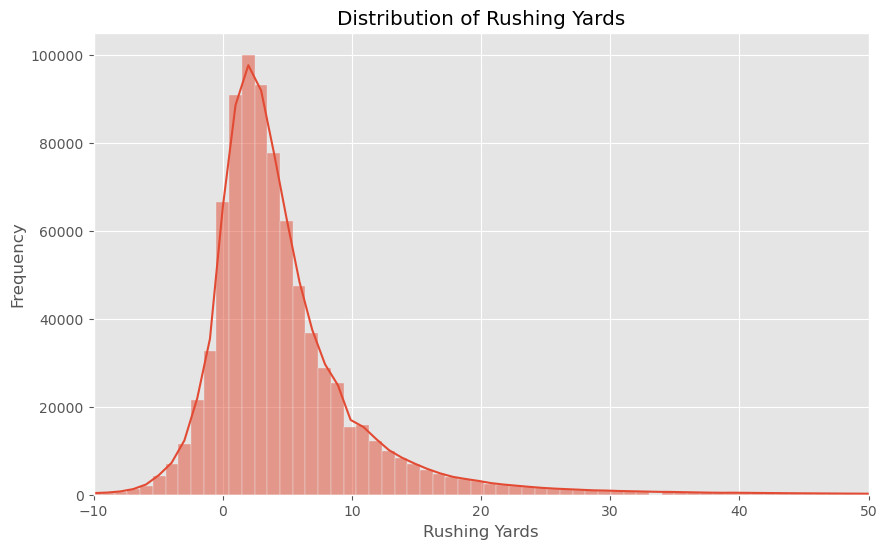

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
sns.histplot(rush_attempts['rush_yards'], bins=200, kde=True)
plt.xlim(-10, 50)
plt.title('Distribution of Rushing Yards')
plt.xlabel('Rushing Yards')
plt.ylabel('Frequency')
plt.show()

In [20]:
rush_attempts.query('rush_yards < -50')[['play_type','play_text']].values

array([['Rush',
        ' aaron zwahlen run for a loss of 60 yards to the hawa 24 '],
       ['Rush',
        ' abraham alce run for a loss of 98 yards to the appst 2 '],
       ['Fumble Recovery (Opponent)',
        ' team run for a loss of 54 yards team fumbled recovered by odu robert kennedy iii   return for 25 yds (ethan sanchez kick) '],
       ['Fumble Recovery (Opponent)',
        ' sam llewellyn run for a loss of 90 yards to the mercr 0 sam llewellyn fumbled forced by ken standley recovered by mercr tj moore '],
       ['Rush', ' bennettjohnathan rush (perrychandler) '],
       ['Rush', ' orlandojake rush (thomasreggie) '],
       ['Rush', ' harmlj rush (angrykevon;aduakachiebuka) '],
       ['Rush', ' davisearnest rush (shegogjamar) '],
       ['Rush', ' chacheredante rush (walkerjordan;brownkameron) '],
       ['Rush', ' doyleoscar rush (leakyusef) '],
       ['Rush', ' harrisayden rush (martintyrell) '],
       ['Rush',
        ' burkettmyles rush middle (lewisjeremiah;howar

# Model 1: Predict Rushing Yards Gained

In [ ]:
id_cols = ['season', 'week', 'season_type', 'play_id', 'drive_id', 'game_id', 'drive_number', 
           'play_number', 'offense', 'defense', 'play_type','play_text']
features = [
    'offense_timeouts', 
    'defense_timeouts',
    'yards_to_goal',
    'score_diff',
    'down', 
    'distance',
    'pct_game_played', 
    'diff_time_ratio', 
    'is_home_team', 
    'offense_elo', 
    'defense_elo', 
    'elo_diff',
    'temperature', 
    'wind_speed', 
    'precipitation',
    'last12_offense_rush_att', 
    'last12_offense_rush_yds',
    'last12_offense_yards_per_rush',
    'last12_offense_rushing_plays_ppa',
    'last12_offense_rushing_plays_success_rate',
    'last12_offense_rushing_plays_explosiveness',
    'last12_offense_stuff_rate', 
    'last12_offense_line_yards',
    'last12_offense_second_level_yards', 
    'last12_offense_open_field_yards',
    'last12_defense_rush_att', 
    'last12_defense_rush_yds',
    'last12_defense_yards_per_rush',
    'last12_defense_rushing_plays_ppa',
    'last12_defense_rushing_plays_success_rate',
    'last12_defense_rushing_plays_explosiveness',
    'last12_defense_stuff_rate', 
    'last12_defense_line_yards',
    'last12_defense_second_level_yards', 
    'last12_defense_open_field_yards', 
    'last6_offense_rush_att', 
    'last6_offense_rush_yds',
    'last6_offense_yards_per_rush',
    'last6_offense_rushing_plays_ppa',
    'last6_offense_rushing_plays_success_rate',
    'last6_offense_rushing_plays_explosiveness',
    'last6_offense_stuff_rate',
    'last6_offense_line_yards', 
    'last6_offense_second_level_yards',
    'last6_offense_open_field_yards', 
    'last6_defense_rush_att', 
    'last6_defense_rush_yds',
    'last6_defense_yards_per_rush',
    'last6_defense_rushing_plays_ppa',
    'last6_defense_rushing_plays_success_rate',
    'last6_defense_rushing_plays_explosiveness',
    'last6_defense_stuff_rate',
    'last6_defense_line_yards',
    'last6_defense_second_level_yards',
    'last6_defense_open_field_yards',
    'last12_offense_rushing_plays_ppa_over_exptd',
    'last12_offense_rushing_plays_success_rate_over_exptd',
    'last12_defense_rushing_plays_ppa_over_exptd',
    'last12_defense_rushing_plays_success_rate_over_exptd',
    'last6_offense_rushing_plays_ppa_over_exptd',
    'last6_offense_rushing_plays_success_rate_over_exptd',
    'last6_defense_rushing_plays_ppa_over_exptd',
    'last6_defense_rushing_plays_success_rate_over_exptd',
]
outcome_cols =['fumble', 'rush_yards',
       'fumble_recovered_by', 'rush_fumble_recovery_yards']

rush_plays = (
    rush_attempts
    .rename(columns={'id': 'play_id'})
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts),
    )
    .query('0 < yards_to_goal < 100 and 0 < distance <= 40 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
    )
    .merge(
        games[['id','season','week','season_type','home_team','neutral_site']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'season_type', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense','season_type'],
        right_on=['season', 'week', 'offense','season_type'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'season_type', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense','season_type'],
        right_on=['season', 'week', 'defense','season_type'],
        how='left'
    )
    .assign(
        elo_diff=lambda x: x.offense_elo - x.defense_elo,
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .assign(
        wind_speed=lambda x: np.where(
            x.game_indoors, 0, x.wind_speed.fillna(int(x.wind_speed.mean()))
        ),
        precipitation=lambda x: np.where(
            x.game_indoors, 0, x.precipitation.fillna(int(x.precipitation.mean()))
        ),
        temperature=lambda x: np.where(
            x.game_indoors, 70, x.temperature.fillna(int(x.temperature.mean()))
        ),
        is_home_team=lambda x: np.where(
            x.neutral_site, 0, np.where(x.offense == x.home_team, 1, -1)
        ),
    )
    .merge(
        rolling_stats_last12[[
            'game_id', 'team',
            'last12_offense_rush_att', 
            'last12_offense_rush_yds',
            'last12_offense_yards_per_rush',
            'last12_offense_rushing_plays_ppa',
            'last12_offense_rushing_plays_success_rate',
            'last12_offense_rushing_plays_explosiveness',
            'last12_offense_stuff_rate', 
            'last12_offense_line_yards',
            'last12_offense_second_level_yards', 
            'last12_offense_open_field_yards',
            'last12_offense_rushing_plays_ppa_over_exptd',
            'last12_offense_rushing_plays_success_rate_over_exptd',
        ]].rename(columns={
            'team': 'offense'
        }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last12[[
            'game_id', 'team',
            'last12_defense_rush_att', 
            'last12_defense_rush_yds',
            'last12_defense_yards_per_rush',
            'last12_defense_rushing_plays_ppa',
            'last12_defense_rushing_plays_success_rate',
            'last12_defense_rushing_plays_explosiveness',
            'last12_defense_stuff_rate', 
            'last12_defense_line_yards',
            'last12_defense_second_level_yards', 
            'last12_defense_open_field_yards', 
            'last12_defense_rushing_plays_ppa_over_exptd',
            'last12_defense_rushing_plays_success_rate_over_exptd',
        ]].rename(columns={
            'team': 'defense'
        }),
        on=['game_id', 'defense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[[
            'game_id', 'team',
            'last6_offense_rush_att', 
            'last6_offense_rush_yds',
            'last6_offense_yards_per_rush',
            'last6_offense_rushing_plays_ppa',
            'last6_offense_rushing_plays_success_rate',
            'last6_offense_rushing_plays_explosiveness',
            'last6_offense_stuff_rate',
            'last6_offense_line_yards', 
            'last6_offense_second_level_yards',
            'last6_offense_open_field_yards', 
            'last6_offense_rushing_plays_ppa_over_exptd',
            'last6_offense_rushing_plays_success_rate_over_exptd',
        ]].rename(columns={
            'team': 'offense'
        }),
        on=['game_id', 'offense'],
        how='left'
    )
    .merge(
        rolling_stats_last6[[
            'game_id', 'team',
            'last6_defense_rush_att', 
            'last6_defense_rush_yds',
            'last6_defense_yards_per_rush',
            'last6_defense_rushing_plays_ppa',
            'last6_defense_rushing_plays_success_rate',
            'last6_defense_rushing_plays_explosiveness',
            'last6_defense_stuff_rate',
            'last6_defense_line_yards',
            'last6_defense_second_level_yards',
            'last6_defense_open_field_yards',
            'last6_defense_rushing_plays_ppa_over_exptd',
            'last6_defense_rushing_plays_success_rate_over_exptd',
        ]].rename(columns={
            'team': 'defense'
        }),
        on=['game_id', 'defense'],
        how='left'
    )
    .dropna(
        subset=[
            'last12_offense_rush_att',
            'last12_defense_rush_att',
        ]
    )
    [id_cols + features + outcome_cols]
)
rush_plays.head()

,season,week,season_type,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,down,distance,pct_game_played,diff_time_ratio,is_home_team,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,last12_offense_rush_att,last12_offense_rush_yds,last12_offense_yards_per_rush,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_offense_stuff_rate,last12_offense_line_yards,last12_offense_second_level_yards,last12_offense_open_field_yards,last12_defense_rush_att,last12_defense_rush_yds,last12_defense_yards_per_rush,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_defense_stuff_rate,last12_defense_line_yards,last12_defense_second_level_yards,last12_defense_open_field_yards,last6_offense_rush_att,last6_offense_rush_yds,last6_offense_yards_per_rush,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_offense_stuff_rate,last6_offense_line_yards,last6_offense_second_level_yards,last6_offense_open_field_yards,last6_defense_rush_att,last6_defense_rush_yds,last6_defense_yards_per_rush,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_defense_stuff_rate,last6_defense_line_yards,last6_defense_second_level_yards,last6_defense_open_field_yards,last12_offense_rushing_plays_ppa_over_exptd,last12_offense_rushing_plays_success_rate_over_exptd,last12_defense_rushing_plays_ppa_over_exptd,last12_defense_rushing_plays_success_rate_over_exptd,last6_offense_rushing_plays_ppa_over_exptd,last6_offense_rushing_plays_success_rate_over_exptd,last6_defense_rushing_plays_ppa_over_exptd,last6_defense_rushing_plays_success_rate_over_exptd,fumble,rush_yards,fumble_recovered_by,rush_fumble_recovery_yards
0,2013,1,postseason,333610120045,33361012006,333610120,6,6,Maryland,Marshall,Rush,levern jacobs rush for 8 yards to the marsh 29,3.0,3.0,37,-7,1,10,0.183333,-14.574064,0,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,427.0,1735.0,4.1,-0.069,0.333,0.85,0.274,2.333,1.127,1.177,524.0,1979.0,3.8,-0.037,0.389,0.823,0.216,2.627,0.966,0.802,195.0,659.0,3.4,-0.023,0.319,0.865,0.263,2.422,1.14,0.827,255.0,1038.0,4.1,0.03,0.401,0.854,0.197,2.9,1.101,0.761,-0.139,-0.078,-0.098,-0.013,-0.089,-0.09,-0.033,-0.002,0,8.0,no-fumble,NaN
1,2013,1,postseason,333610120043,33361012006,333610120,6,4,Maryland,Marshall,Rush,brandon ross rush for 4 yards to the mary 49,3.0,3.0,55,-7,1,10,0.169167,-13.771164,0,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,427.0,1735.0,4.1,-0.069,0.333,0.85,0.274,2.333,1.127,1.177,524.0,1979.0,3.8,-0.037,0.389,0.823,0.216,2.627,0.966,0.802,195.0,659.0,3.4,-0.023,0.319,0.865,0.263,2.422,1.14,0.827,255.0,1038.0,4.1,0.03,0.401,0.854,0.197,2.9,1.101,0.761,-0.139,-0.078,-0.098,-0.013,-0.089,-0.09,-0.033,-0.002,0,4.0,no-fumble,NaN
2,2013,1,postseason,333610120042,33361012006,333610120,6,3,Maryland,Marshall,Rush,brandon ross rush for 11 yards to the mary 45...,3.0,3.0,66,-7,3,1,0.162778,-13.423693,0,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,427.0,1735.0,4.1,-0.069,0.333,0.85,0.274,2.333,1.127,1.177,524.0,1979.0,3.8,-0.037,0.389,0.823,0.216,2.627,0.966,0.802,195.0,659.0,3.4,-0.023,0.319,0.865,0.263,2.422,1.14,0.827,255.0,1038.0,4.1,0.03,0.401,0.854,0.197,2.9,1.101,0.761,-0.139,-0.078,-0.098,-0.013,-0.089,-0.09,-0.033,-0.002,0,11.0,no-fumble,NaN
3,2013,1,postseason,333610120041,33361012006,333610120,6,2,Maryland,Marshall,Rush,cj brown rush for 4 yards to the mary 34,3.0,3.0,70,-7,2,5,0.150556,-12.783207,0,1921.246102,1703.121251,218.124852,46.0,9.2,0.0,427.0,1735.0,4.1,-0.069,0.333,0.85,0.274,2.333,1.127,1.177,524.0,1979.0,3.8,-0.037,0.389,0.823,0.216,2.627,0.966,0.802,195.0,659.0,3.4,-0.023,0.319,0.865,0.263,2.422,1.14,0.827,255.0,1038.0,4.1,0.03,0.401,0.854,0.197,2.9,1.101,

In [91]:
feature_names = [
    # 'offense_timeouts', 
    # 'defense_timeouts',
    'yards_to_goal',
    # 'score_diff',
    'down', 
    'distance',
    # 'pct_game_played', 
    'diff_time_ratio', 
    # 'is_home_team', 
    # 'offense_elo', 
    # 'defense_elo', 
    'elo_diff',
    # 'temperature', 
    # 'wind_speed', 
    # 'precipitation',
    # 'last12_offense_rush_att', 
    # 'last12_offense_rush_yds',
    # 'last12_offense_yards_per_rush',
    # 'last12_offense_rushing_plays_ppa',
    # 'last12_offense_rushing_plays_success_rate',
    # 'last12_offense_rushing_plays_ppa_over_exptd',
    'last12_offense_rushing_plays_success_rate_over_exptd',
    # 'last12_offense_rushing_plays_explosiveness',
    # 'last12_offense_stuff_rate', 
    # 'last12_offense_line_yards',
    # 'last12_offense_second_level_yards', 
    # 'last12_offense_open_field_yards',
    # 'last12_defense_rush_att', 
    # 'last12_defense_rush_yds',
    # 'last12_defense_yards_per_rush',
    # 'last12_defense_rushing_plays_ppa',
    # 'last12_defense_rushing_plays_success_rate',
    # 'last12_defense_rushing_plays_ppa_over_exptd',
    'last12_defense_rushing_plays_success_rate_over_exptd',
    # 'last12_defense_rushing_plays_explosiveness',
    # 'last12_defense_stuff_rate', 
    # 'last12_defense_line_yards',
    # 'last12_defense_second_level_yards', 
    # 'last12_defense_open_field_yards', 
    # 'last6_offense_rush_att', 
    # 'last6_offense_rush_yds',
    # 'last6_offense_yards_per_rush',
    # 'last6_offense_rushing_plays_ppa',
    # 'last6_offense_rushing_plays_success_rate',
    # 'last6_offense_rushing_plays_explosiveness',
    # 'last6_offense_stuff_rate',
    # 'last6_offense_line_yards', 
    # 'last6_offense_second_level_yards',
    # 'last6_offense_open_field_yards', 
    # 'last6_defense_rush_att', 
    # 'last6_defense_rush_yds',
    # 'last6_defense_yards_per_rush',
    # 'last6_defense_rushing_plays_ppa',
    # 'last6_defense_rushing_plays_success_rate',
    # 'last6_defense_rushing_plays_explosiveness',
    # 'last6_defense_stuff_rate',
    # 'last6_defense_line_yards',
    # 'last6_defense_second_level_yards',
    # 'last6_defense_open_field_yards',
]

target_variable = 'rush_yards'

data = (
    # Minimum 10 yards lost on rush in dataset, beyond that likely involved a fumble
    rush_plays.query('-10 <= rush_yards <= 100')
    [feature_names + [target_variable]].copy()
)

SEED = 2

binned_y = pd.qcut(data[target_variable], q=5, labels=False)

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=binned_y
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

binned_y_train = pd.qcut(train_data[target_variable], q=5, labels=False)

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify= binned_y_train
)

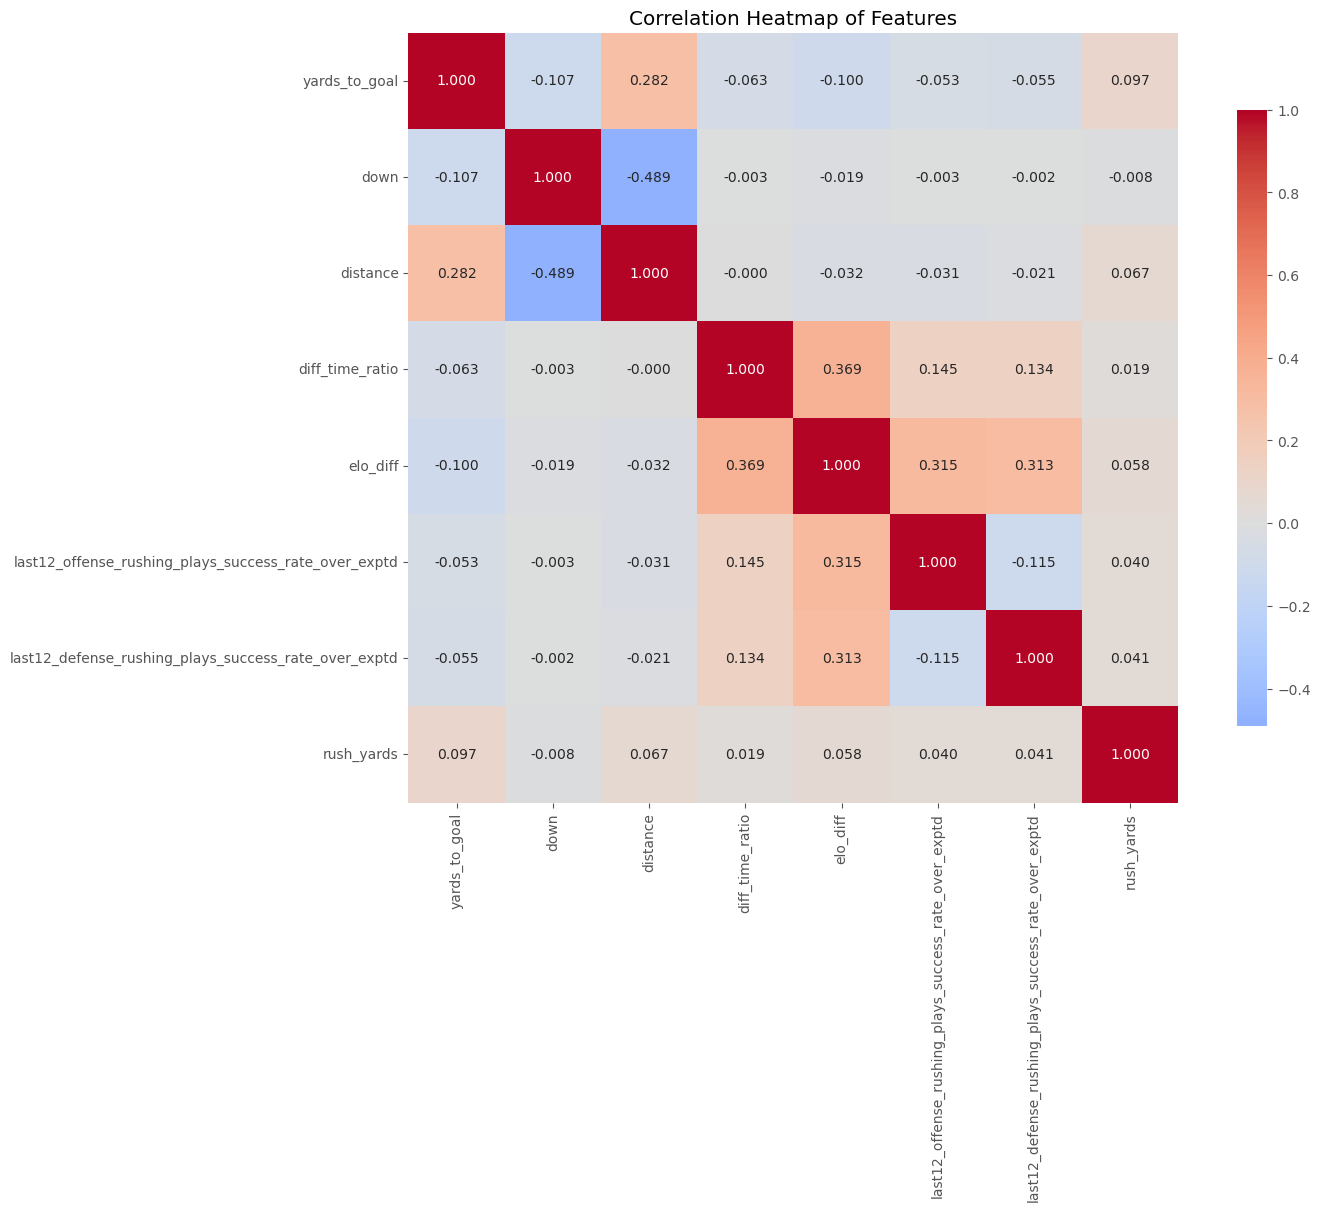

In [92]:
# correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    rush_plays[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [93]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

monotonic_constraints_map = {
    'yards_to_goal': 1, # father away, more room to gain yards
    # 'score_diff': 1, # larger positive score diff indicates better team
    'down': 1, # later downs generally shorter distance to gain, congested running lanes
    'distance': 1, # larger distance generally means more yards gained
    # 'pct_game_played': 0,
    'diff_time_ratio': 0, # team could be losing badly and defense sacrifices rushing yards
    # 'is_home_team': 1, # home field advantage
    'elo_diff': 1, # larger positive elo diff indicates better team
    # 'last12_offense_yards_per_rush': 1, # better historical rushing performance
    # 'last12_offense_rushing_plays_ppa': 1, # better historical rushing performance
    # 'last12_offense_rushing_plays_success_rate': 1, # better historical rushing performance
    # 'last12_offense_rushing_plays_ppa_over_exptd': 1, # better historical rushing performance
    'last12_offense_rushing_plays_success_rate_over_exptd': 1, # better historical rushing performance
    # 'last12_defense_yards_per_rush': 1, # worse historical defense rushing performance
    # 'last12_defense_rushing_plays_ppa': 1, # worse historical defense rushing performance
    # 'last12_defense_rushing_plays_success_rate': 1, # worse historical defense rushing performance
    # 'last12_defense_rushing_plays_ppa_over_exptd': 1, # worse historical defense rushing performance
    'last12_defense_rushing_plays_success_rate_over_exptd': 1, # worse historical defense rushing performance
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# constraint_groups = [
#     ['pct_game_played', 'score_diff']
# ]
# feature_index_map = {name: i for i, name in enumerate(feature_names)}
# interaction_constraints = []
# for group in constraint_groups:
#     interaction_constraints.append([feature_index_map[f] for f in group])

# Train models for different quantiles
# quantiles = [0.025, 0.5, 0.975]
quantiles = [0.5]
quantile_models = {}

for quantile in quantiles:
    # Objective function for Optuna tuning
    def objective(trial, dtrain, dvalid):
        param = {
            "nthread": -1,
            "objective": "reg:quantileerror",
            "eval_metric": "mae",
            "booster": "gbtree",
            "quantile_alpha": quantile,
            "monotone_constraints": monotonic_constraints,
            # "interaction_constraints": interaction_constraints,
            "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
            "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10, step=0.5),
            "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "seed": SEED,
        }

        bst = xgb.train(
            param,
            dtrain,
            num_boost_round=500,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=10,
            verbose_eval=False,
        )
        preds = bst.predict(dvalid)
        return mean_absolute_error(valid_y, preds)

    # Run Optuna study
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(
        study_name=f"rush_yards_gained_quantile_{quantile}",
        direction="minimize",
        load_if_exists=False,
        sampler=sampler
    )
    study.optimize(lambda trial: objective(trial, dtrain, dvalid), n_trials=1, show_progress_bar=True)

    # Train final model with best parameters
    best_params = {
        **study.best_trial.params,
        'monotone_constraints': monotonic_constraints,
        # 'interaction_constraints': interaction_constraints,
        'nthread': -1,
        'objective': 'reg:quantileerror',
        'quantile_alpha': quantile,
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'seed': SEED,
    }

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    
    quantile_models[quantile] = final_model

# Make predictions for each quantile
for quantile in quantiles:
    rush_plays[f'predicted_rush_yards_gained_{int(quantile*100)}'] = quantile_models[quantile].predict(
        xgb.DMatrix(rush_plays[feature_names])
    )


from sklearn.metrics import mean_absolute_error, r2_score
# Helper to compute metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_pred = quantile_models[0.5].predict(dmatrix)

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Mean Absolute Error : {mae:.4f}")
    print(f"R^2 Score           : {r2:.4f}") 

# Evaluate the median quantile model (0.5)
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)

  0%|          | 0/1 [00:00<?, ?it/s]


=== TRAIN SET METRICS ===
Mean Absolute Error : 4.2183
R^2 Score           : -0.0233

=== VALIDATION SET METRICS ===
Mean Absolute Error : 4.2410
R^2 Score           : -0.0261

=== TEST SET METRICS ===
Mean Absolute Error : 4.2446
R^2 Score           : -0.0247


In [94]:
# baseline model which predicts the mean yards gained
baseline_mean = train_y.median()
baseline_preds = np.full_like(valid_y, baseline_mean)  
baseline_mae = mean_absolute_error(valid_y, baseline_preds)
print(f"Baseline Mean MAE: {baseline_mae:.4f}")

Baseline Mean MAE: 4.3338


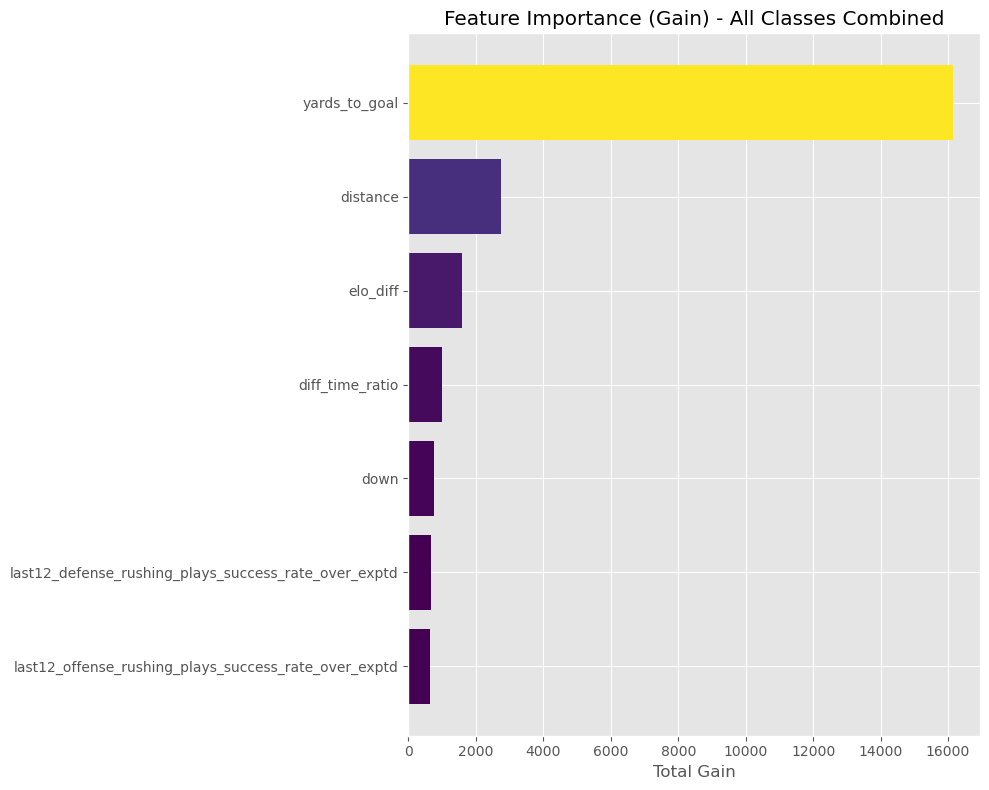

In [95]:
import matplotlib.cm as cm

trees_df = quantile_models[0.5].trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


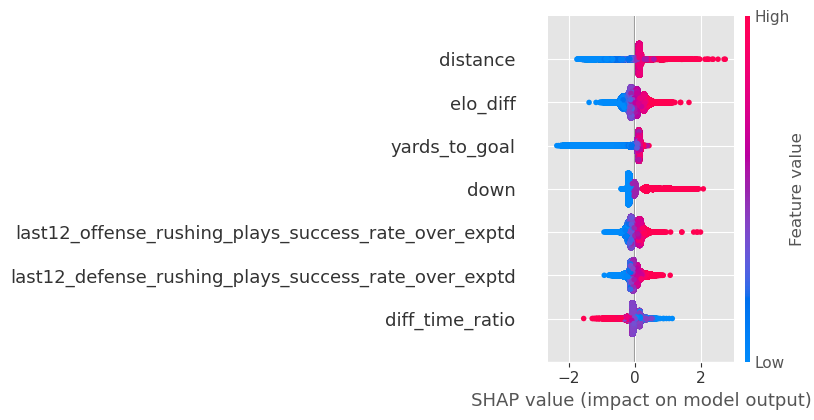

In [96]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(quantile_models[0.5])  # Use the median quantile model

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

In [100]:
rush_plays.sort_values(by='predicted_rush_yards_gained_50', ascending=False).head()

,season,week,season_type,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,down,distance,pct_game_played,diff_time_ratio,is_home_team,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,last12_offense_rush_att,last12_offense_rush_yds,last12_offense_yards_per_rush,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_offense_stuff_rate,last12_offense_line_yards,last12_offense_second_level_yards,last12_offense_open_field_yards,last12_defense_rush_att,last12_defense_rush_yds,last12_defense_yards_per_rush,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_defense_stuff_rate,last12_defense_line_yards,last12_defense_second_level_yards,last12_defense_open_field_yards,last6_offense_rush_att,last6_offense_rush_yds,last6_offense_yards_per_rush,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_offense_stuff_rate,last6_offense_line_yards,last6_offense_second_level_yards,last6_offense_open_field_yards,last6_defense_rush_att,last6_defense_rush_yds,last6_defense_yards_per_rush,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_defense_stuff_rate,last6_defense_line_yards,last6_defense_second_level_yards,last6_defense_open_field_yards,last12_offense_rushing_plays_ppa_over_exptd,last12_offense_rushing_plays_success_rate_over_exptd,last12_defense_rushing_plays_ppa_over_exptd,last12_defense_rushing_plays_success_rate_over_exptd,last6_offense_rushing_plays_ppa_over_exptd,last6_offense_rushing_plays_success_rate_over_exptd,last6_defense_rushing_plays_ppa_over_exptd,last6_defense_rushing_plays_success_rate_over_exptd,fumble,rush_yards,fumble_recovered_by,rush_fumble_recovery_yards,predicted_rush_yards_gained_50
72421,2014,2,regular,400547826104977401,40054782629,400547826,29,3,Ohio State,Virginia Tech,Rush,jt barrett run for 22 yds to the ohst 41 for ...,1.0,2.0,81,-7,3,20,0.959722,-325.316657,1,3058.426633,2576.174869,482.251764,66.9,8.1,0.0,535.0,3659.0,6.8,0.273,0.562,0.877,0.129,3.910,1.731,1.629,399.0,1311.0,3.3,-0.100,0.285,0.999,0.248,2.286,0.900,1.100,255.0,1805.0,7.1,0.281,0.548,0.974,0.129,3.809,1.758,1.830,196.0,790.0,4.0,-0.070,0.265,1.205,0.257,2.081,0.823,1.563,0.207,0.154,-0.193,-0.139,0.220,0.141,-0.161,-0.158,0,22.0,no-fumble,NaN,11.283380
129190,2015,1,regular,400756905101894901,4007569052,400756905,2,7,Ohio State,Virginia Tech,Rush,cardale jones run for 16 yds to the vtech 34,3.0,3.0,50,0,3,21,0.069444,0.000000,-1,3192.059595,2380.262739,811.796857,75.9,3.4,0.0,557.0,3381.0,6.1,0.321,0.549,1.089,0.144,3.483,1.504,2.288,456.0,1806.0,4.0,0.061,0.364,1.156,0.226,2.497,1.135,1.749,257.0,1625.0,6.3,0.306,0.498,1.195,0.154,3.182,1.359,2.931,251.0,1019.0,4.1,-0.017,0.317,1.199,0.241,2.484,1.059,1.706,0.269,0.148,-0.038,-0.064,0.264,0.102,-0.116,-0.111,0,16.0,no-fumble,NaN,10.253513
396600,2019,5,regular,401112117102965001,40111211710,401112117,10,9,Oklahoma,Texas Tech,Rush,trey sermon run for 13 yds to the textc 41,2.0,2.0,54,14,3,24,0.436389,80.207168,1,3218.313847,2156.206562,1062.107284,80.2,11.9,0.0,473.0,3410.0,7.2,0.414,0.559,1.104,0.168,3.619,1.720,2.947,493.0,1954.0,4.0,0.036,0.408,0.842,0.197,2.891,1.004,1.222,227.0,1569.0,6.9,0.349,0.539,1.050,0.183,3.379,1.679,3.121,284.0,999.0,3.5,-0.009,0.368,0.792,0.187,2.835,0.732,0.851,0.357,0.155,-0.067,-0.023,0.294,0.136,-0.096,-0.051,0,13.0,no-fumble,NaN,10.038111
107013,2014,11,regular,400548346103888801,40054834613,400548346,13,9,Auburn,Texas A&M,Rush,cameron artis-payne run for 25 yds to the aub...,3.0,3.0,95,-18,3,35,0.563611,-171.539953,1,2978.303607,2725.185235,253.118372,61.0,0.0,0.0,612.0,3611.0,5.9,0.176,0.496,0.816,0.142,3.462,1.362,1.502,500.0,2383.0,4.8,0.137,0.445,0.915,0.178,3.162

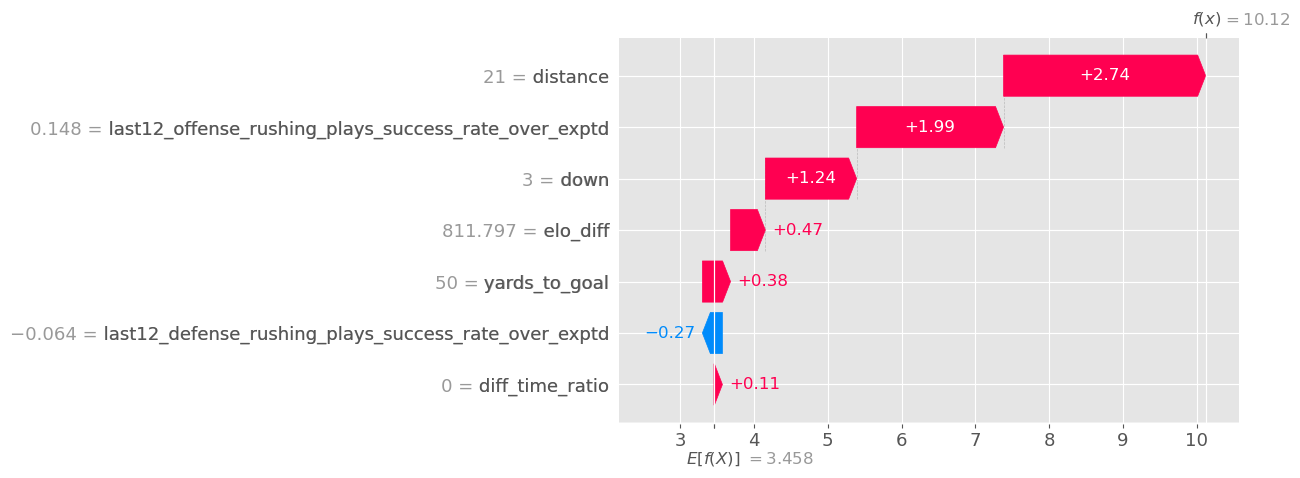

In [102]:
idx = rush_plays.sort_values(by='predicted_rush_yards_gained_50', ascending=False).index[1]

game_data = rush_plays.loc[rush_plays.index == idx, feature_names].copy()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [124]:
rush_plays.sort_values(by='predicted_rush_yards_gained_50', ascending=True).head()

,season,week,season_type,play_id,drive_id,game_id,drive_number,play_number,offense,defense,play_type,play_text,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,down,distance,pct_game_played,diff_time_ratio,is_home_team,offense_elo,defense_elo,elo_diff,temperature,wind_speed,precipitation,last12_offense_rush_att,last12_offense_rush_yds,last12_offense_yards_per_rush,last12_offense_rushing_plays_ppa,last12_offense_rushing_plays_success_rate,last12_offense_rushing_plays_explosiveness,last12_offense_stuff_rate,last12_offense_line_yards,last12_offense_second_level_yards,last12_offense_open_field_yards,last12_defense_rush_att,last12_defense_rush_yds,last12_defense_yards_per_rush,last12_defense_rushing_plays_ppa,last12_defense_rushing_plays_success_rate,last12_defense_rushing_plays_explosiveness,last12_defense_stuff_rate,last12_defense_line_yards,last12_defense_second_level_yards,last12_defense_open_field_yards,last6_offense_rush_att,last6_offense_rush_yds,last6_offense_yards_per_rush,last6_offense_rushing_plays_ppa,last6_offense_rushing_plays_success_rate,last6_offense_rushing_plays_explosiveness,last6_offense_stuff_rate,last6_offense_line_yards,last6_offense_second_level_yards,last6_offense_open_field_yards,last6_defense_rush_att,last6_defense_rush_yds,last6_defense_yards_per_rush,last6_defense_rushing_plays_ppa,last6_defense_rushing_plays_success_rate,last6_defense_rushing_plays_explosiveness,last6_defense_stuff_rate,last6_defense_line_yards,last6_defense_second_level_yards,last6_defense_open_field_yards,last12_offense_rushing_plays_ppa_over_exptd,last12_offense_rushing_plays_success_rate_over_exptd,last12_defense_rushing_plays_ppa_over_exptd,last12_defense_rushing_plays_success_rate_over_exptd,last6_offense_rushing_plays_ppa_over_exptd,last6_offense_rushing_plays_success_rate_over_exptd,last6_defense_rushing_plays_ppa_over_exptd,last6_defense_rushing_plays_success_rate_over_exptd,fumble,rush_yards,fumble_recovered_by,rush_fumble_recovery_yards,predicted_rush_yards_gained_50
331094,2018,4,regular,401013128103928108,40101312820,401013128,20,8,Old Dominion,Virginia Tech,Rush,lala davis run for no gain to the vtech 1,3.0,3.0,1,-7,1,1,0.628333,-86.422105,1,1367.594424,2710.842954,-1343.248530,82.9,8.0,0.0,443.0,1915.0,4.3,0.034,0.363,0.988,0.221,2.580,0.924,1.347,408.0,1323.0,3.2,-0.151,0.274,1.211,0.315,1.778,0.842,1.211,202.0,901.0,4.5,0.070,0.416,0.914,0.240,2.534,0.983,1.591,196.0,586.0,3.0,-0.210,0.247,1.386,0.364,1.391,0.718,1.336,-0.073,-0.067,-0.256,-0.158,-0.044,-0.018,-0.312,-0.183,0,0.0,no-fumble,NaN,-0.773308
505624,2021,8,regular,401287926103986901,4012879269,401287926,9,13,Kansas,Oklahoma,Rushing Touchdown,devin neal run for 1 yd for a td (jacob borci...,3.0,3.0,1,10,4,1,0.725000,181.741454,1,1418.571387,3336.303147,-1917.731760,55.2,10.6,0.0,462.0,1388.0,3.0,0.015,0.325,1.066,0.225,2.602,0.798,0.955,382.0,1298.0,3.4,0.046,0.359,1.033,0.236,2.512,1.021,1.203,229.0,892.0,3.9,0.077,0.391,0.911,0.156,3.023,0.878,1.171,185.0,629.0,3.4,-0.050,0.381,0.710,0.221,2.508,0.996,1.143,-0.046,-0.081,-0.058,-0.073,0.004,-0.022,-0.148,-0.046,0,1.0,no-fumble,NaN,-0.759253
342631,2018,7,regular,401013147104909510,40101314724,401013147,24,10,North Carolina,Virginia Tech,Fumble Recovery (Opponent),michael carter run for no gain to the vtech 2...,3.0,3.0,1,5,1,1,0.848889,149.156109,1,2079.201325,2593.985214,-514.783888,57.2,0.0,0.0,419.0,1837.0,4.4,0.096,0.423,1.025,0.215,2.783,1.275,1.504,410.0,1335.0,3.3,-0.118,0.281,1.324,0.324,1.711,0.817,1.491,210.0,1108.0,5.3,0.155,0.460,1.050,0.206,2.842,1.290,1.788,191.0,640.0,3.4,-0.032,0.278,1.599,0.319,1.765,0.823,1.924,0.033,0.016,-0.221,-0.150,0.083,0.048,-0.135,-0.152,1,0.0,defense,0.0,-0.749887
625165,2023,1,postseason,401551780104998901,40155178025,401551780,25,9,Tennessee,Iowa,Rush,khalifa keith run for 1 yd to the iowa 2 for ...,3.0,2.0,3,35,4,1,0.997222,1889.820161,0,2798.386672,2765.929730,32.456942,68.0,11.8,0.0,435.0,2430.0,5.6,0.206,0.453,1.052,0.119,3.337,1.344,1.944,420.0,1

In [128]:
rush_plays.drop_duplicates('game_id').sort_values(by='last12_offense_rushing_plays_success_rate_over_exptd', ascending=False).drop_duplicates('offense')[['season','week','offense','last12_offense_rushing_plays_success_rate_over_exptd']].head(20)

,season,week,offense,last12_offense_rushing_plays_success_rate_over_exptd
708007,2023,13,LSU,0.185
299735,2017,12,Ohio State,0.180
552153,2022,3,Oregon,0.174
373286,2019,1,Wisconsin,0.163
657499,2023,5,Oregon State,0.163
598512,2022,10,Georgia,0.163
679577,2023,9,Arizona,0.159
650648,2023,4,UCLA,0.157
145110,2015,4,Georgia Tech,0.157
597654,2022,10,Michigan,0.154


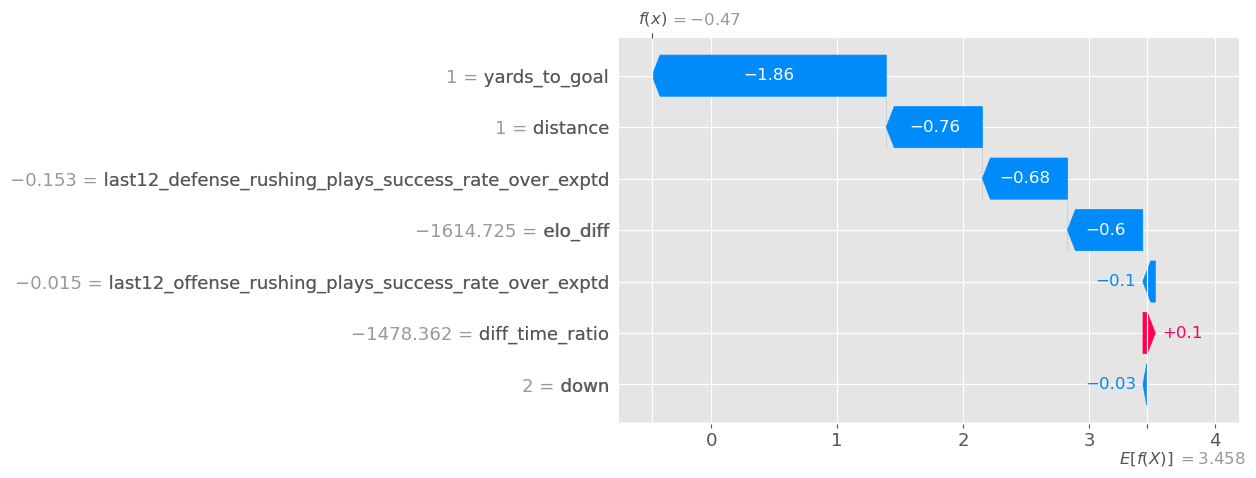

In [109]:
idx = rush_plays.sort_values(by='predicted_rush_yards_gained_50', ascending=True).index[7]

game_data = rush_plays.loc[rush_plays.index == idx, feature_names].copy()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [ ]:
n_between = rush_plays.query(
    'predicted_rush_yards_gained_2 <= rush_yards <= predicted_rush_yards_gained_97'
).shape[0]
n_total = rush_plays.shape[0]
print(f"Percentage of rush yards between 2.5 and 97.5 quantiles: {n_between / n_total:.2%}")

Percentage of rush yards between 2.5 and 97.5 quantiles: 94.65%


In [108]:
model_dir = join('../models/raw', 'run')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for q_name, q in zip(["q025", "q50", "q975"], [0.025, 0.5, 0.975]):
    model_path = os.path.join(model_dir, f"rush_yards_gained_{q_name}_xgb.bin")
    quantile_models[q].save_model(model_path)
    print(f"Saved quantile {q_name} model to '{model_path}'")

Saved quantile q025 model to '../models/raw/run/rush_yards_gained_q025_xgb.bin'
Saved quantile q50 model to '../models/raw/run/rush_yards_gained_q50_xgb.bin'
Saved quantile q975 model to '../models/raw/run/rush_yards_gained_q975_xgb.bin'


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_17878/3606073003.py:7: UserWarning: [19:22:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  quantile_models[q].save_model(model_path)


# Model 2: Predict if there was a rushing fumble

In [141]:
rush_plays.fumble.value_counts(normalize=True)

fumble
0    0.982773
1    0.017227
Name: proportion, dtype: float64

# Model 3: Predict if there was a fumble and who recovered
50 - 50 chance of recovery offense or defense

In [118]:
rush_plays.query('fumble == 1 and fumble_recovered_by.isin(["offense","defense"])').fumble_recovered_by.value_counts(normalize=True)

fumble_recovered_by
offense    0.507534
defense    0.492466
Name: proportion, dtype: float64

# Model 4: Predict yards gained on fumble recover

Offensive Recovery Yards Lost Stats:
count    5389.000000
mean       -1.231954
std         8.867875
min       -90.000000
25%        -5.000000
50%        -2.000000
75%         2.000000
max        74.000000
Name: recovery_yards_lost, dtype: float64

Defensive Recovery Yards Lost Stats:
count    5229.000000
mean       -0.719449
std        13.682607
min       -99.000000
25%        -4.000000
50%         1.000000
75%         5.000000
max        68.000000
Name: recovery_yards_lost, dtype: float64


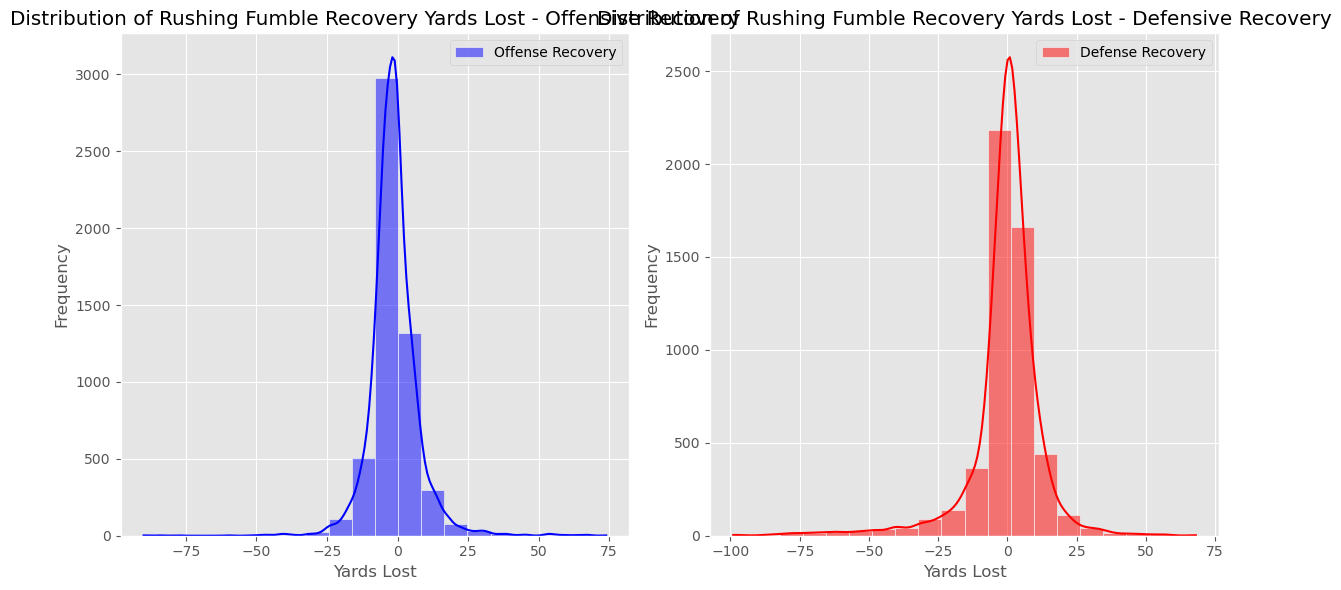

In [133]:
qry = (
    rush_plays
    .query('fumble == 1 and fumble_recovered_by.isin(["offense","defense"])')
    .assign(
        recovery_yards_lost = lambda x:
            x.rush_yards - x.rush_fumble_recovery_yards
    )
)
feature = 'recovery_yards_lost'

# plot two histograms side by side, for sack fumble yards lost by offense and defense
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(
    qry.query('fumble_recovered_by == "offense"')[feature],
    bins=20, kde=True, color='blue', label='Offense Recovery'
)
print("Offensive Recovery Yards Lost Stats:")
print(qry.query('fumble_recovered_by == "offense"')[feature].describe())
plt.title('Distribution of Rushing Fumble Recovery Yards Lost - Offensive Recovery')
plt.xlabel('Yards Lost')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1, 2, 2)
sns.histplot(
    qry.query('fumble_recovered_by == "defense"')[feature],
    bins=20, kde=True, color='red', label='Defense Recovery'
)
print("\nDefensive Recovery Yards Lost Stats:")
print(qry.query('fumble_recovered_by == "defense"')[feature].describe())
plt.title('Distribution of Rushing Fumble Recovery Yards Lost - Defensive Recovery')
plt.xlabel('Yards Lost')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [138]:
# Save the empirical distribution of rushing fumble recovery yards lost by offense and defense
qry = (
    rush_plays
    .query('fumble == 1 and fumble_recovered_by.isin(["offense","defense"])')
    .assign(
        recovery_yards_lost = lambda x:
            x.rush_yards - x.rush_fumble_recovery_yards
    )
)

rush_fumble_yards_lost_offense = (
    qry
    .query('recovery_yards_lost >= -20')
    [['recovery_yards_lost']]
    .value_counts(normalize=True)
    .reset_index(name='proportion')
    .rename(columns={'recovery_yards_lost': 'yards_lost'})
    .sort_values(by='yards_lost', ascending=True, ignore_index=True)
)
rush_fumble_yards_lost_defense = (
    qry
    [['recovery_yards_lost']]
    .value_counts(normalize=True)
    .reset_index(name='proportion')
    .rename(columns={'recovery_yards_lost': 'yards_lost'})
    .sort_values(by='yards_lost', ascending=True, ignore_index=True)
)

model_dir = join('../models/raw', 'run')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

rush_fumble_yards_lost_offense.to_parquet(
    join(model_dir, 'rush_fumble_yards_lost_offense.parquet'),
    index=False
)
rush_fumble_yards_lost_defense.to_parquet(
    join(model_dir, 'rush_fumble_yards_lost_defense.parquet'),
    index=False
)